# Вектор Шепли в машинном обучениии и его визуализация

## 1. Поработаем свектором Шепли

### 1.1 Обучим модель

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from IPython.display import display

from sklearn.datasets import load_breast_cancer
#plt.style.use('default')

import shap
print (shap.__version__)

0.48.0


Используем датасет <code>cancer</code> и случайный лес. Обучимся и посмотрим результат.

Важная особенность! Для простоты дальнейшей работы с библиотекой `SHAP` признаки `X` должны быть в виде `pd.DataFrame` с именами столбцов.

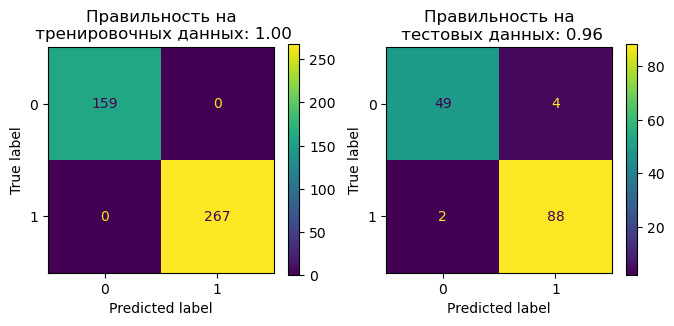

In [4]:
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns = data.feature_names)
y = data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify=y)
forest = RandomForestClassifier(n_estimators = 500, random_state = 42)
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)
y_pred_proba = forest.predict_proba(X_test)

fig, ax = plt.subplots(1,2, figsize=(8,3))
ConfusionMatrixDisplay.from_estimator(forest, X_train, y_train, ax = ax[0]);
ax[0].set_title( "Правильность на\n тренировочных данных: {:.2f}".format(forest.score(X_train, y_train)) )
ConfusionMatrixDisplay.from_estimator(forest, X_test, y_test, ax = ax[1]);
ax[1].set_title( "Правильность на\n тестовых данных: {:.2f}".format(forest.score(X_test, y_test)) );


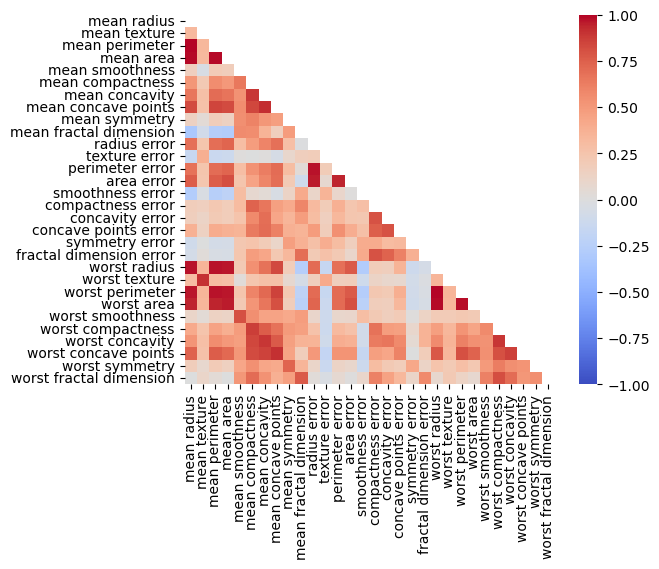

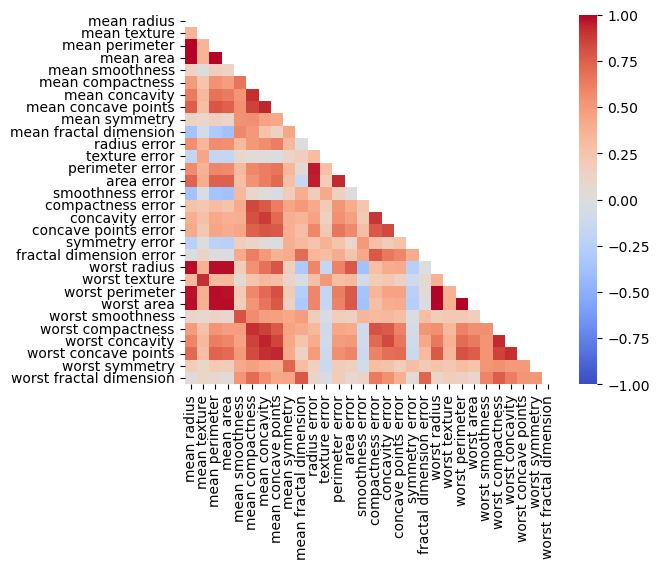

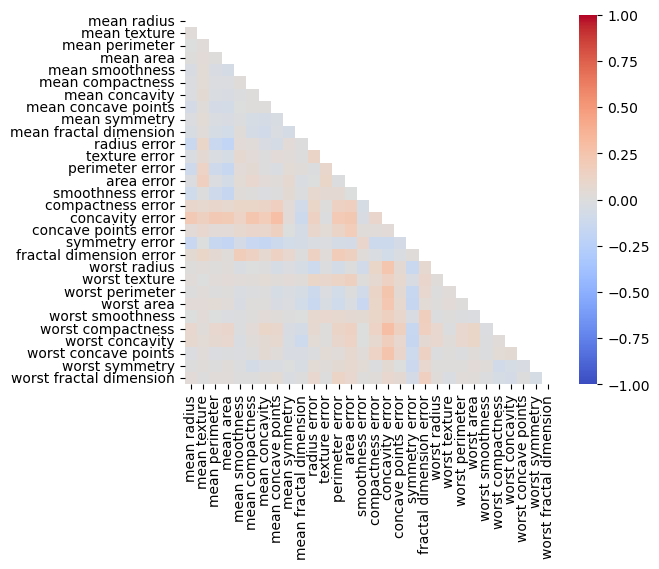

In [5]:
import seaborn as sns

# Коэффициент корреляции Пирсона (отдельная тема можно ли использовать), если кратко, то нет

corr = X_train.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            mask=mask,
            square=True,
            vmin = -1, vmax = 1,
           cmap ='coolwarm')
plt.show()

# Коэффициент корреляции Спирмена (отдельная тема можно ли использовать)
corr1 = X_train.corr(method = 'spearman')
mask = np.zeros_like(corr1)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr1, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            mask=mask,
            square=True,
            vmin = -1, vmax = 1,
           cmap ='coolwarm')
plt.show()

# разница расчета коэффицентов корреляции Пирсона и Спирмена
sns.heatmap(corr1-corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            mask=mask,
            square=True,
            vmin = -1, vmax = 1,
           cmap ='coolwarm')
plt.show()

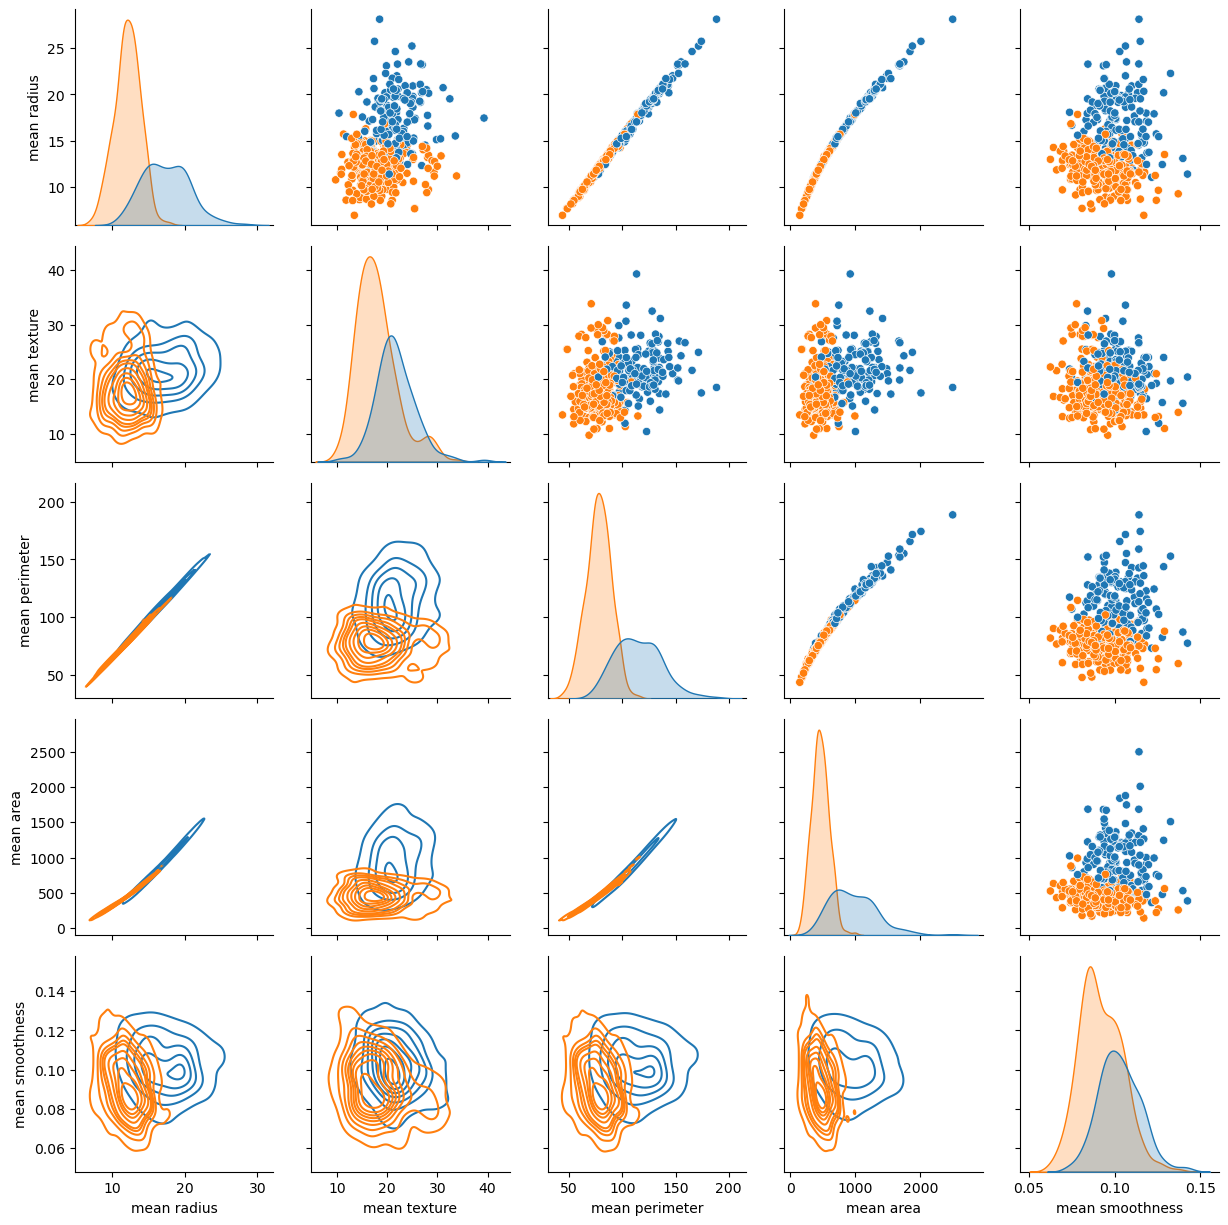

In [6]:
# так как в априории мы не знаем как распределены данные, мы используем коэфициент корреляции Спирмена
df = pd.concat([X_train.iloc[:,:5], pd.DataFrame(y_train, index = X_train.index, columns = ['target'])], axis=1)

g = sns.PairGrid(df, diag_sharey=False, hue = 'target') 
# Внимание! diag_sharey=False необходимо, для корректного отображения распределений на главой диагонали 
g.map_upper(sns.scatterplot)
g.map_diag(sns.kdeplot, fill=True);
g.map_lower(sns.kdeplot);

Используем метод `Explainer`(дословно рус. - объяснитель, скорее правильнее переводить как интерпритатор) для фиксации метода рассчета значимости(важности) векторов Шепли на для конкрентного алгоритма машинного обучения на фиксированных данных (обычно тренировочном наборе). 

Используя `shap_values` расчитаем значения векторов Шепли для конкретного набора данных. Для исследования данных используем тренировочные наборы, для понимания результата используем тестовые наборы данных. 

In [7]:
import shap

explainer = shap.Explainer(forest)
shap_values = explainer.shap_values(X_train)

shap_values.shape

(426, 30, 2)

In [8]:
X_train.shape

(426, 30)

In [9]:
shap_values[:,:,0].shape

(426, 30)

In [10]:
shap_values[:,:,1].shape

(426, 30)

Приведем два самых простых примеров.</br>
Посмотрим значимость признаков для модели случайного леса в среднем для класса 0 и 1.

In [11]:
feature_names = data.feature_names

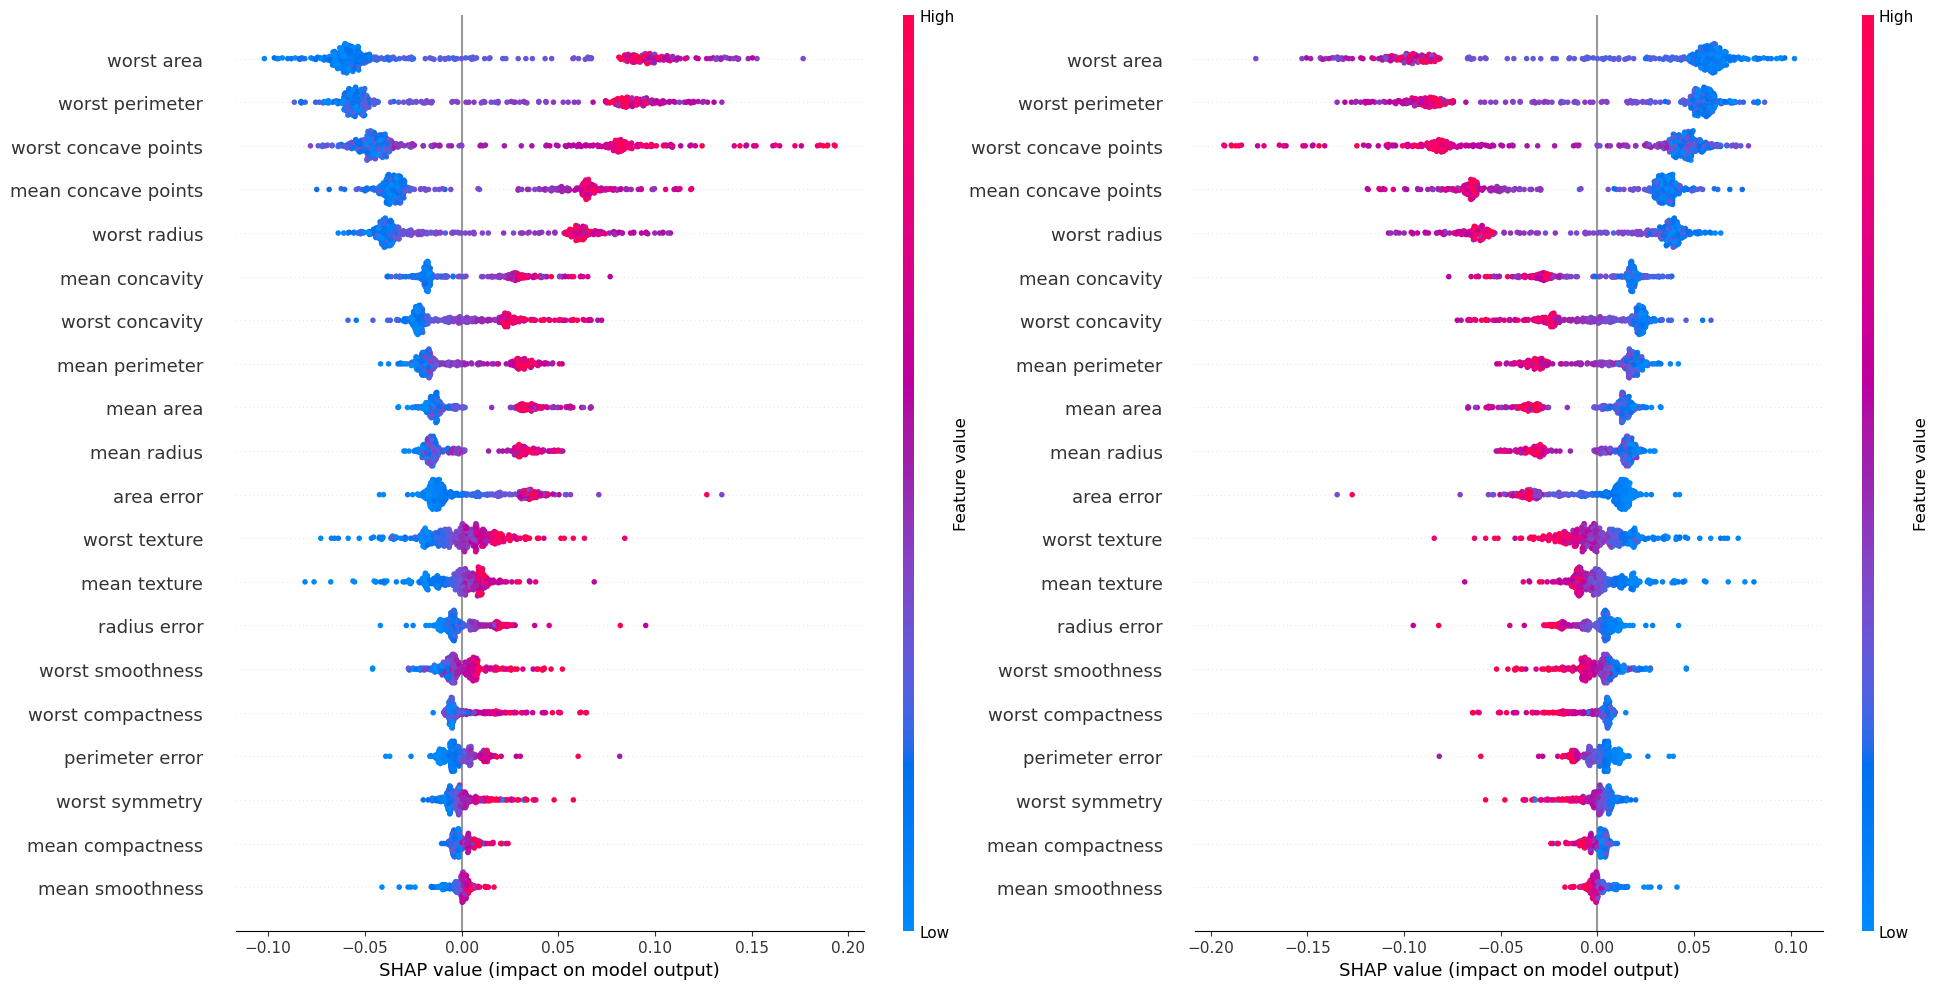

In [12]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
shap.summary_plot(shap_values = shap_values[:,:,0], 
                  features = X_train,
                  feature_names=feature_names, 
                  plot_size=None, show=False
                 ) # это нужно только для отрисовки графиков рядом в subplot
plt.subplot(1,2,2)
shap.summary_plot(shap_values[:,:,1], X_train, feature_names=feature_names, plot_size=None, show=False)
plt.show()

Каждая горизонтальная линия соответствует одному признаку `feature_names`, и на этой линии отмечаются точки, соответствующие тестовым примерам: кордината точки на линии соответствует значению вектора Шепли `shap_values` , цвет точки - значению признака `features`. Если в каком-то участке линии не хватает места для всех точек, линия начинает расти в ширину. Таким образом, для каждого признака схема представляет собой слившееся множество точек, по одной точке для каждого примера.

Значение `Feature value`  на графике слева показывает в нашем случае близость значения полученного вектора к искомому классу. В нашем случае синий это класc 0, красный класс 1. 

Обратите внимание, что графики симметричны для 0 и 1 класса. Поэтому для задачи бинарной класиификации можно использовать любой из графиков. **Удобнее использовать результат для нулевого класса указывая** `shap_values[:,:,0]`. 
**Для первого класса** `shap_values[:,:,1]` **результат будет учитываться с обратным знаком.**


Теперь приведем пример для конкретного значения из тестовой выборки и посмотрим какие признаки повлиялияли на соотнесение к конкретному классу.

In [13]:
explainer.expected_value[1]

0.6260610328638493

In [14]:
shap.initjs()

explainer = shap.Explainer(forest)
shap_values_test = explainer.shap_values(X_test)

i = 1
print('Предсказан класс: ', y_pred[i], ' с вероятностью ', y_pred_proba[:,y_pred[i]][i])

print('Обоснование предсказанного класса: ')
shap.force_plot( base_value = explainer.expected_value[1], # базовое 
                 shap_values = shap_values_test[i,:,1],
                 features = X_test.iloc[i], 
                 feature_names = feature_names)

Предсказан класс:  0  с вероятностью  1.0
Обоснование предсказанного класса: 


Посмотрим как влияют фичи на конкретное предсказанное значение.</br>
Каждый класс предсказан с вероятностью рассчитаной с `predict_proba`. График  `force_plot` позволяет посмотреть, какие признаки и как сильно повлияли на это. </br>
В данном случае для начальной точки построения находим базовое значение прогноза,  а затем смотрим каие признаки сдвигают конкретный прогноз относительно базового вправо или влево. 

Возможно более показателен, но менее компактен график `waterfall_plot`. 

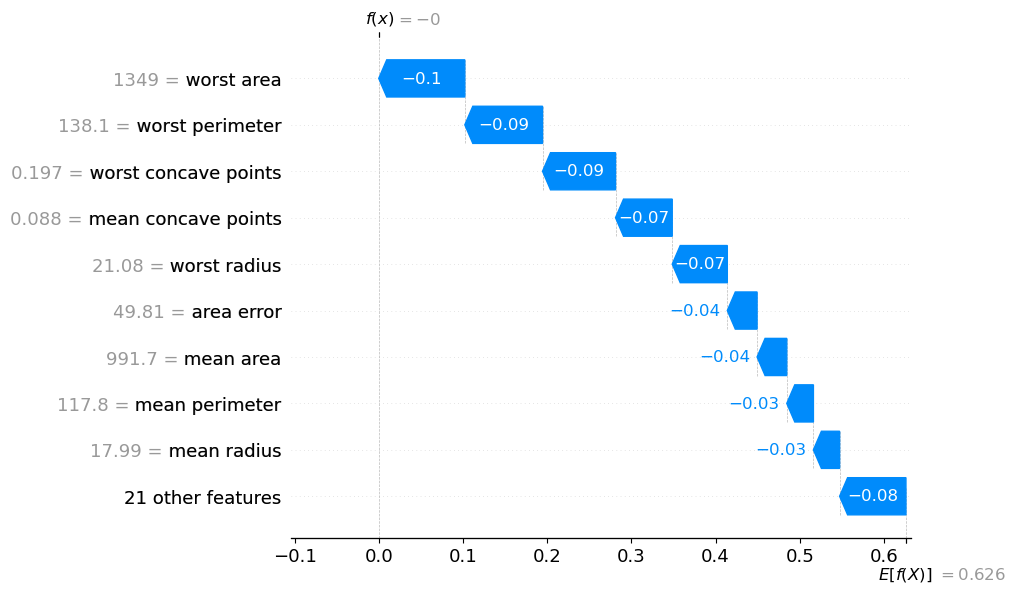

In [15]:
method = explainer(X_test)
explanation = shap.Explanation(
                  values = method.values[:,:,1], 
                  base_values = explainer.expected_value[1], #method.base_values[:,1], 
                  data=X_test.values, 
                  feature_names = feature_names)

shap.plots.waterfall(explanation[1], max_display=10)

Важная особенность! Для построения графика `waterfall_plot` нам нужно специальным образом "упакопать данные". Для упаковки используется метод `Explanation`. Данные упаковываем следующим образом:
1. Значение векторов `values` Шепли для данного класса (адрес [:, :, n], где n конкретный класс из N классов задачи классификаци).
2. Базовое значение векторов Шепли `base_values` для данного класса (адрес [:, n], где n конкретный класс из N классов задачи классификаци).
3. Данные `data`, они обязательно должны совпадать с данными в подставленными в метод  `explainer`, иначе будет получена неправильная расшифровка значений признаков на оси "Y".
4. Имена колонок признаков `feature_names`.

### Крайне важный коментарий о применимости векторов Шепли

Важно понимать, что вектора Шепли являются инструментом оценки важности признаков относительно данной, фиксисованой, выбраной вами модели. Важность признаков модели и истинная важность признаков, это мяго говоря большая разница. 

Если ваша модель дейтвительно хорошо отражает "реальный мир", тогда ваши вектора Шепли будут отражать реальность.



### Сравнение результатов 

Сравним результаты нахождения самых "важных признаков" SHAP и "классики" - иерархической кластеризация с использованием связей Варда.

Для получения сопаставимых результатов с предидущем примером упакуем тренировочный набор данных

In [16]:
method_train = explainer(X_train)
explanation_train = shap.Explanation(
                  values = method_train.values[:,:,1], 
                  base_values =  method_train.base_values[:,1], 
                  data = X_train.values, 
                  feature_names = feature_names)

Построим два графика `summary_plot` и `beeswarm`. Последний график ограничивается построением заданного числа главных признаков и суумарным отображением остальных признаков.  Очевидно, что упаковка данных упрощает код, дл отображения графиков.

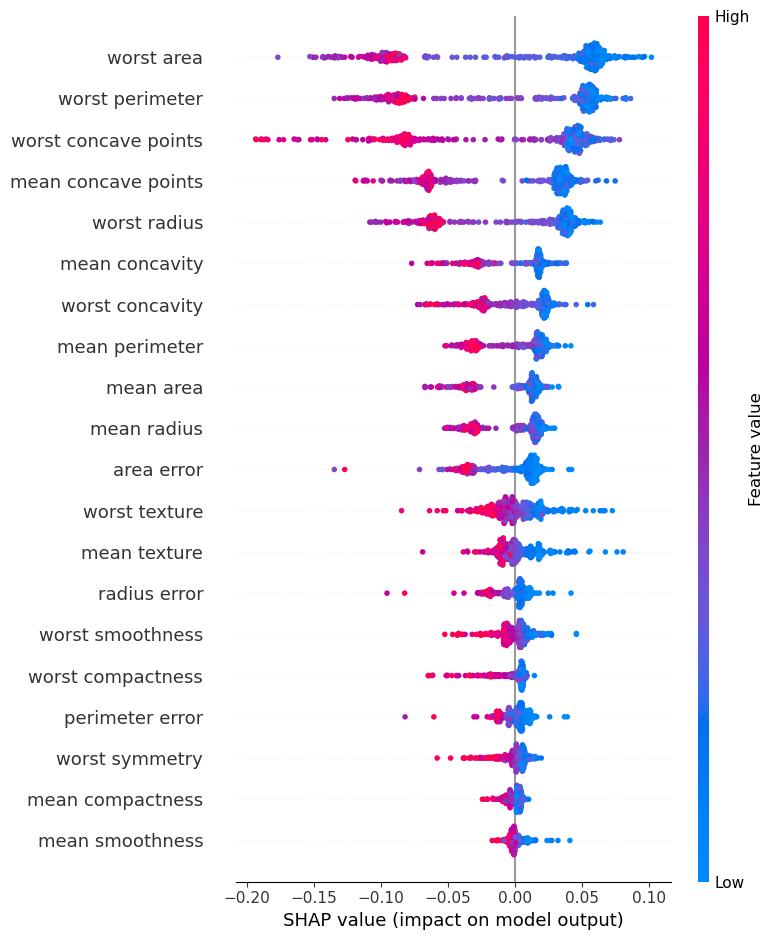

In [17]:
shap.summary_plot(explanation_train, show=False) # это нужно только для отрисовки графиков рядом в subplot

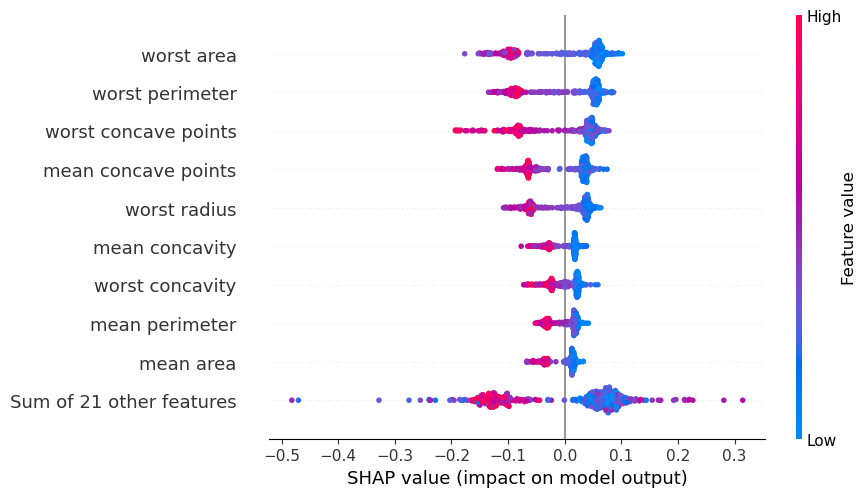

In [18]:
shap.plots.beeswarm(explanation_train, max_display=10)

Так как по неизвестной причине в пакете SHAP нет определенной команды для получения 
списка наиболее важных признаков, напишим такую функцию. 

In [21]:
def shapley_feature_ranking(explanation,func = np.mean):
    '''
    func по умолчанию np.mean, но можно заменить например на np.max
    '''
    feature_order = np.argsort(func(np.abs(explanation.values), axis=0))
    
    return pd.DataFrame(
        {
            "features": [explanation.feature_names[i] for i in feature_order][::-1],
            "importance": [
                func(np.abs(explanation.values), axis=0)[i] for i in feature_order
            ][::-1],
        }
    )

important_feature = shapley_feature_ranking(explanation_train)
display(important_feature.head(5))

,features,importance
0,worst area,0.068572
1,worst perimeter,0.063760
2,worst concave points,0.060114
3,mean concave points,0.047003
4,worst radius,0.045009


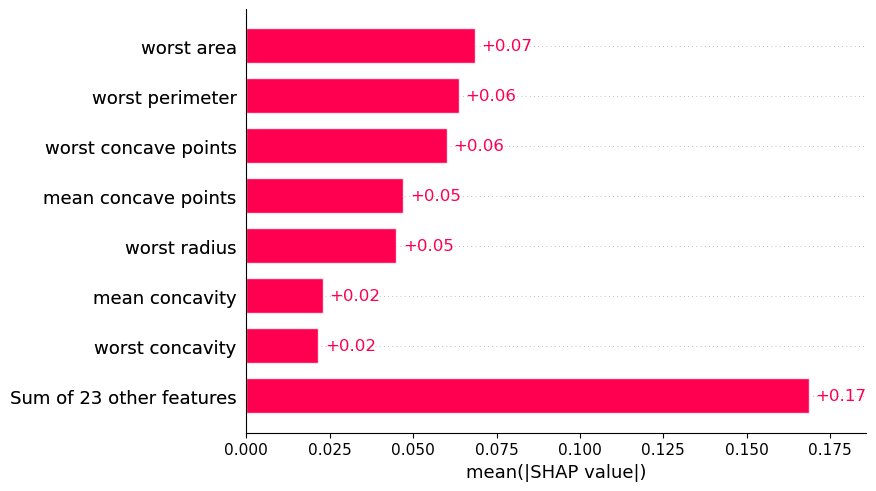

In [22]:
shap.plots.bar(explanation_train, max_display=8)

Важно помнить, что по умолчанию признаки упорядочены с использованием shap_values.abs.mean(0), что является средним абсолютным значением значений SHAP для каждого признака. 

Однако при данном упорядочивании больше внимания уделяется значениям более близким к среднему и меньшее к более редким, но значительным воздействиям (выбросам). 

Если мы хотим найти признаки в которых оказывается большее влияние оказывается выбросами, мы можем вместо mean отсортировать их по максимальному абсолютному значению:

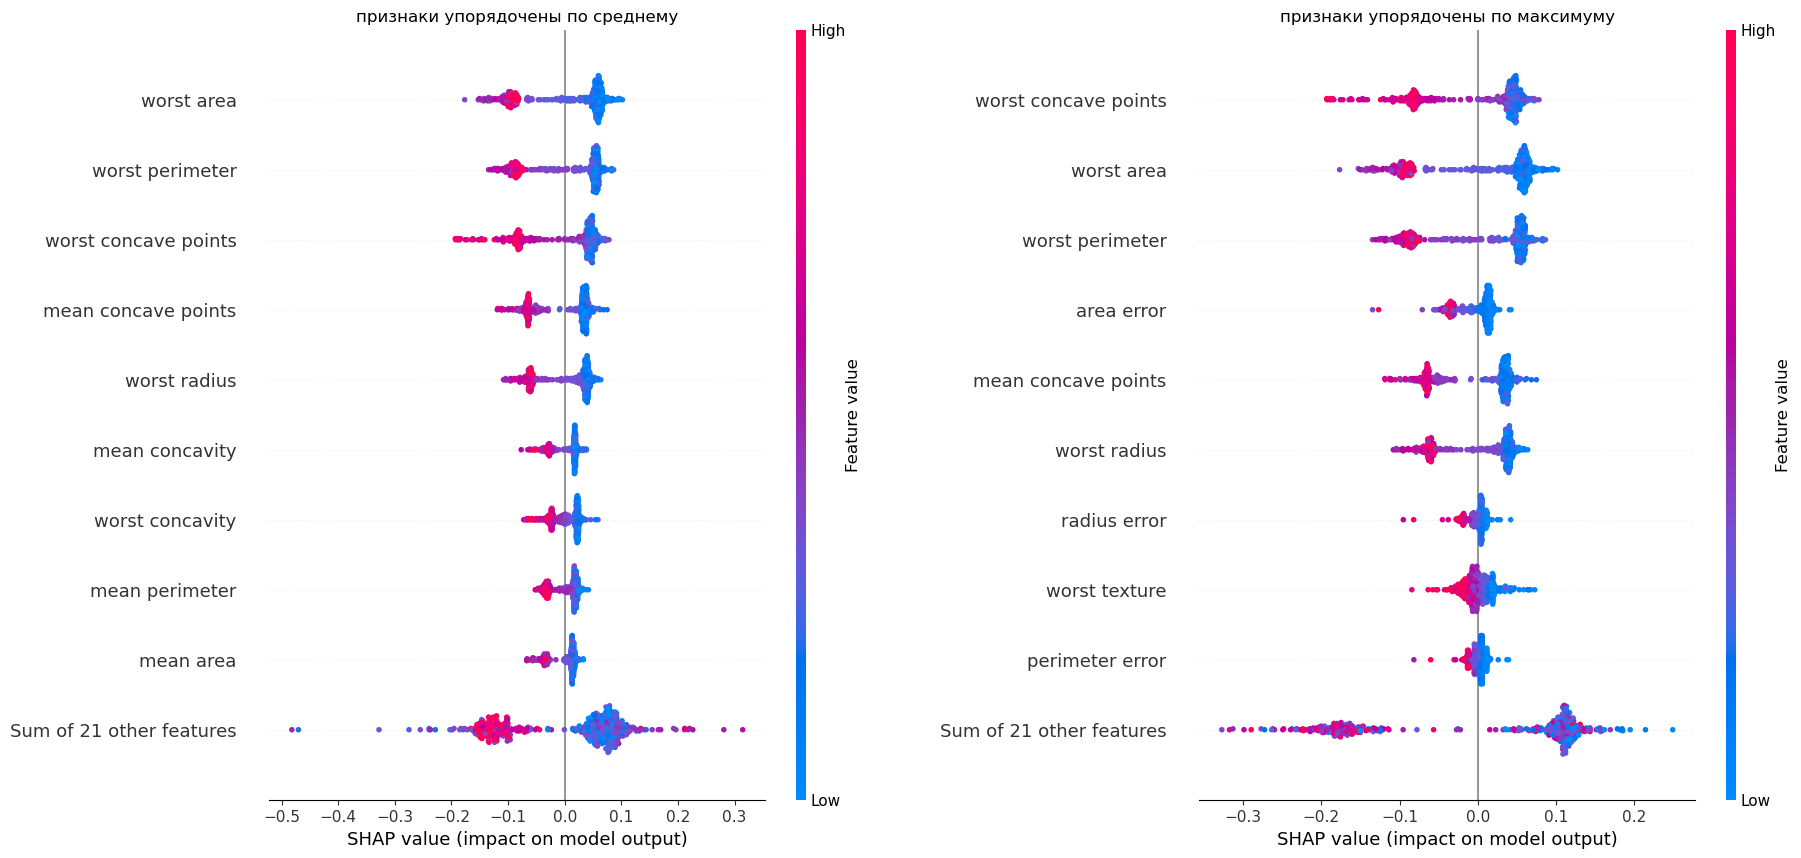

In [23]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
shap.plots.beeswarm(explanation_train, order = explanation_train.abs.mean(0), 
                  plot_size=None, show=False) 
plt.title('признаки упорядочены по среднему')
plt.subplot(1,2,2)
shap.plots.beeswarm(explanation_train, order = explanation_train.abs.max(0),
                    plot_size=None, show=False)
plt.title('признаки упорядочены по максимуму')
plt.subplots_adjust(wspace = 0.5)# это нужно только для разрыва в графиках

Accuracy on train data with features removed: 1.00
Accuracy on test data with features removed: 0.93
['worst area' 'worst perimeter' 'worst concave points'
 'mean concave points' 'worst radius']


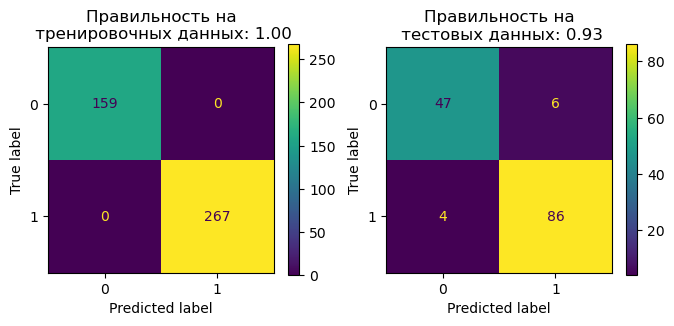

In [24]:
selected_features = important_feature['features'].values[:5]

X_train_sel = X_train[selected_features]
X_test_sel = X_test[selected_features]

clf_sel = RandomForestClassifier(n_estimators=500, random_state=210)
clf_sel.fit(X_train_sel, y_train)
print( "Accuracy on train data with features removed: {:.2f}".format(
        clf_sel.score(X_train_sel, y_train)
    ))
print( "Accuracy on test data with features removed: {:.2f}".format(
        clf_sel.score(X_test_sel, y_test)
    ))

y_pred_train = clf_sel.predict(X_train_sel)
y_pred = clf_sel.predict(X_test_sel)

fig, ax = plt.subplots(1,2, figsize=(8,3))
ConfusionMatrixDisplay.from_estimator(clf_sel, X_train_sel, y_train, ax = ax[0]);
ax[0].set_title( "Правильность на\n тренировочных данных: {:.2f}".format(clf_sel.score(X_train_sel, y_train)) )
ConfusionMatrixDisplay.from_estimator(clf_sel, X_test_sel, y_test, ax = ax[1]);
ax[1].set_title( "Правильность на\n тестовых данных: {:.2f}".format(clf_sel.score(X_test_sel, y_test)) );
print(selected_features)

Посмотрев на аналогичый результат отбора наиболее важных признаков в модели с одинаковыми настройками для случайного леса, но исользовав другой метод отбора наиболее важных признаков - иерархической кластеризации с использованием связей Варда (см. ранее), проведя ряд сопоставимы "прогонов задач", можно в целом сказать, метод с использованием векторов Шепли, дает устойчиво несколько лучший результат выделения наиболее значимых признаков.

И в завершении отметим на ранее построенной дендрограмме 5 наилучших признаков выделенных через вектора Шепли, чтобы наклядно сравнить результаты двух вариантов :)

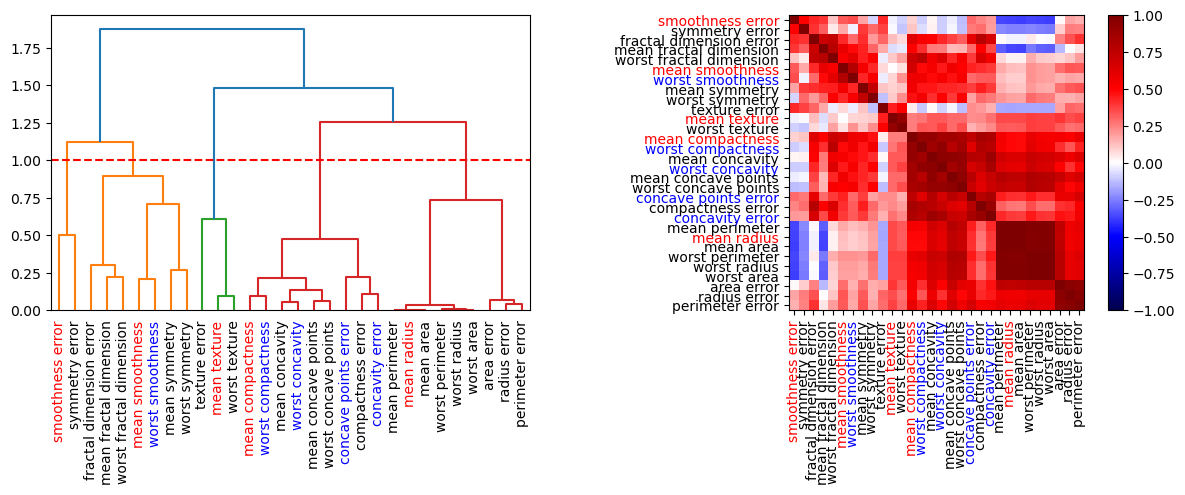

In [25]:
from scipy.stats import spearmanr
from scipy.spatial.distance import squareform
from scipy.cluster import hierarchy

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
corr = spearmanr(X_train).correlation

corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)


distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
    dist_linkage, labels = data.feature_names,
    ax=ax1, leaf_rotation=90
)
selected_features_inx = [dendro['ivl'].index(i) for i in selected_features]

ax1.axhline(y=1, color='r', linestyle='--')
[ax1.get_xticklabels()[dendro["leaves"].index(i)].set_color('blue') for i  in selected_features_inx];
[ax1.get_xticklabels()[dendro["leaves"].index(i)].set_color('red') for i  in [0, 1, 4, 5, 14]];# вектора из предидущего занятия

dendro_idx = np.arange(0, len(dendro["ivl"]))

im2 = ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]], cmap='seismic')
im2.set_clim(-1,1)

ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(data.feature_names[dendro["leaves"]], rotation="vertical")
ax2.set_yticklabels(data.feature_names[dendro["leaves"]])

fig.tight_layout()

[ax2.get_xticklabels()[dendro["leaves"].index(i)].set_color('blue') for i  in selected_features_inx];
[ax2.get_xticklabels()[dendro["leaves"].index(i)].set_color('red') for i  in [0, 1, 4, 5, 14]];
[ax2.get_yticklabels()[dendro["leaves"].index(i)].set_color('blue') for i  in selected_features_inx];
[ax2.get_yticklabels()[dendro["leaves"].index(i)].set_color('red') for i  in [0, 1, 4, 5, 14]];
# [ax2.get_xticklabels()[dendro["leaves"].index(i)].set_bbox(dict(                                                               
#                                                                 color='yellow', 
#                                                                 alpha=0.5, 
#                                                                 )) for i  in selected_features_inx];

fig.colorbar(im2, ax=ax2);

plt.show()

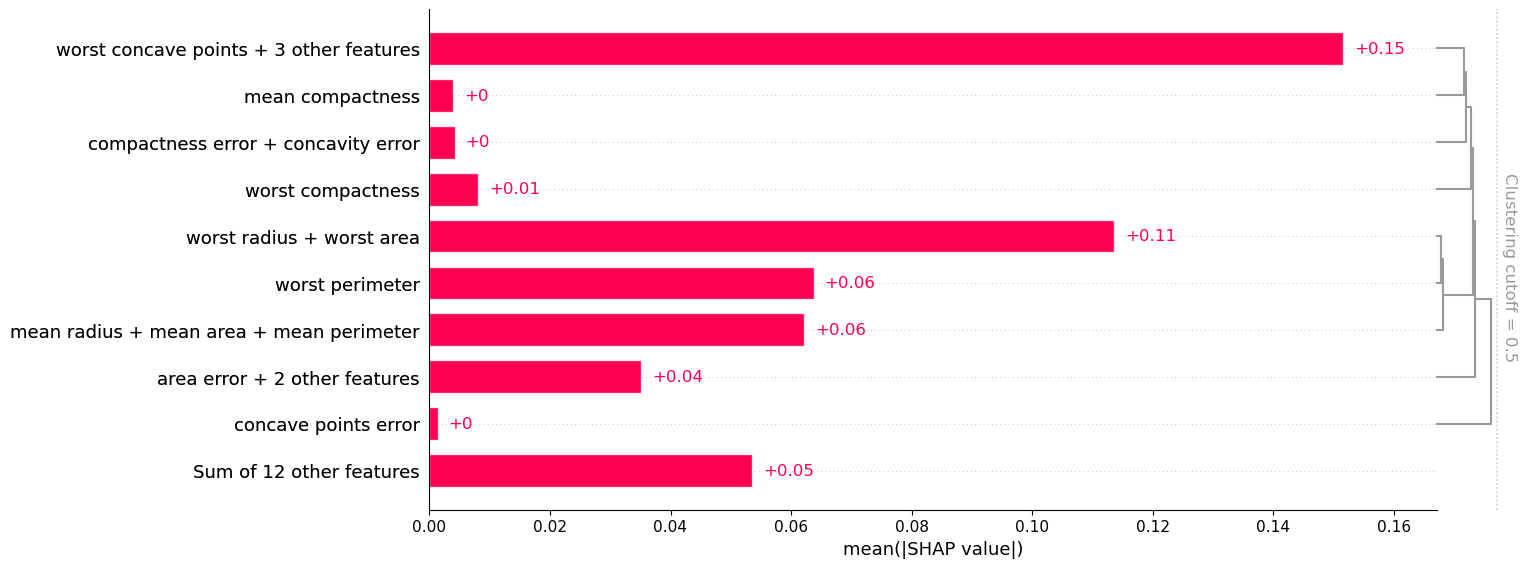

In [26]:
clustering = shap.utils.hclust(X_train, y_train)
shap.plots.bar(explanation_train, clustering=clustering, show = False)
_, h = plt.gcf().get_size_inches()
plt.gcf().set_size_inches(2*h, h)
plt.show()

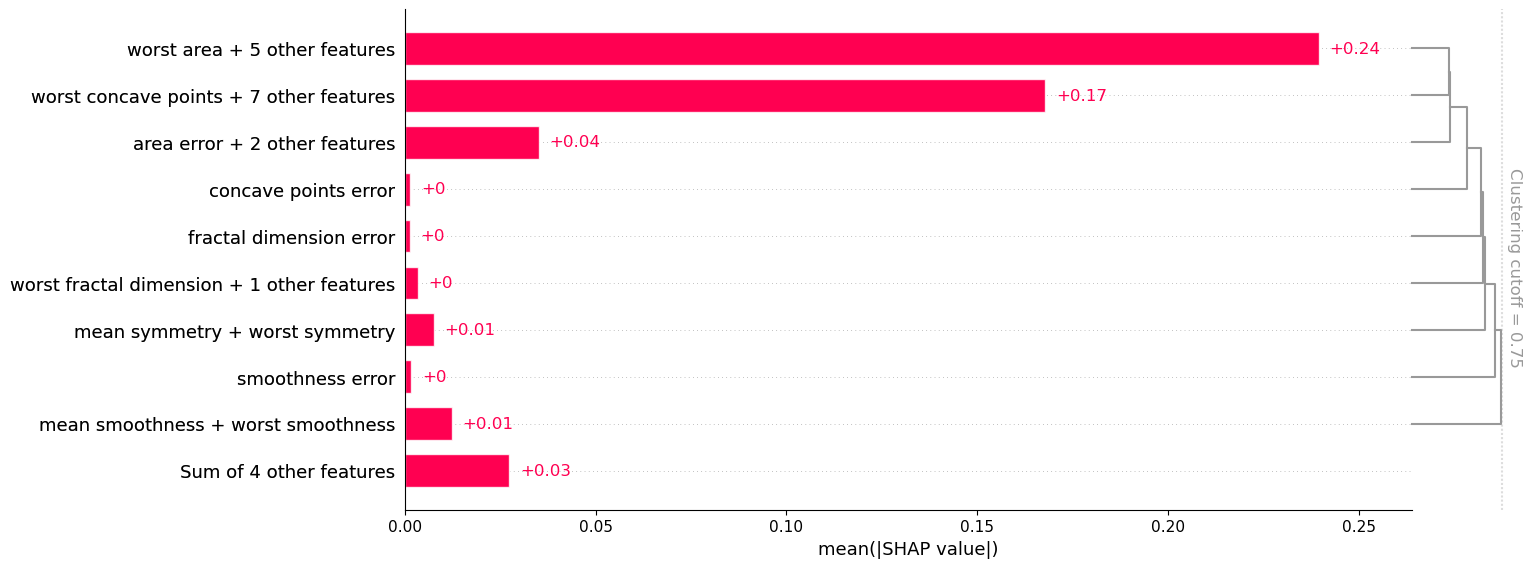

In [27]:
shap.plots.bar(explanation_train, clustering=clustering, clustering_cutoff=0.75, show = False)
_, h = plt.gcf().get_size_inches()
plt.gcf().set_size_inches(2*h, h)
plt.show()

In [28]:
display(important_feature.head(6))

,features,importance
0,worst area,0.068572
1,worst perimeter,0.063760
2,worst concave points,0.060114
3,mean concave points,0.047003
4,worst radius,0.045009
5,mean concavity,0.022898
